# download packages

In [41]:
pip install tensorflow-model-optimization

Note: you may need to restart the kernel to use updated packages.


In [42]:
import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Import the libraries

In [3]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt


# Data Pre-Process

In [4]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/", '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)' 
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [5]:
data = pd.read_csv(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/",'HAM10000_metadata.csv'))

In [6]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [7]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...


In [8]:
# Adding image pixels and resize image
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((48,48))))

In [9]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[191, 151, 192], [192, 152, 195], [194, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[23, 13, 24], [30, 19, 38], [60, 42, 68], [9..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[187, 130, 143], [195, 140, 155], [199, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[26, 13, 21], [51, 29, 40], [89, 58, 70], [1..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[145, 100, 124], [169, 125, 151], [191, 143,..."


<Figure size 1584x2304 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Actinic keratoses (akiec)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Actinic keratoses (akiec)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Actinic keratoses (akiec)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Basal cell carcinoma (bcc)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Basal cell carcinoma (bcc)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Basal cell carcinoma (bcc)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Benign keratosis-like lesions (bkl)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Benign keratosis-like lesions (bkl)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Benign keratosis-like lesions (bkl)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Dermatofibroma (df)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Dermatofibroma (df)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Dermatofibroma (df)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Melanoma (mel)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Melanoma (mel)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Melanoma (mel)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Melanocytic nevi (nv)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Melanocytic nevi (nv)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Melanocytic nevi (nv)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Vascular lesions (vasc)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Vascular lesions (vasc)')

(-0.5, 47.5, 47.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Vascular lesions (vasc)')

(-0.5, 47.5, 47.5, -0.5)

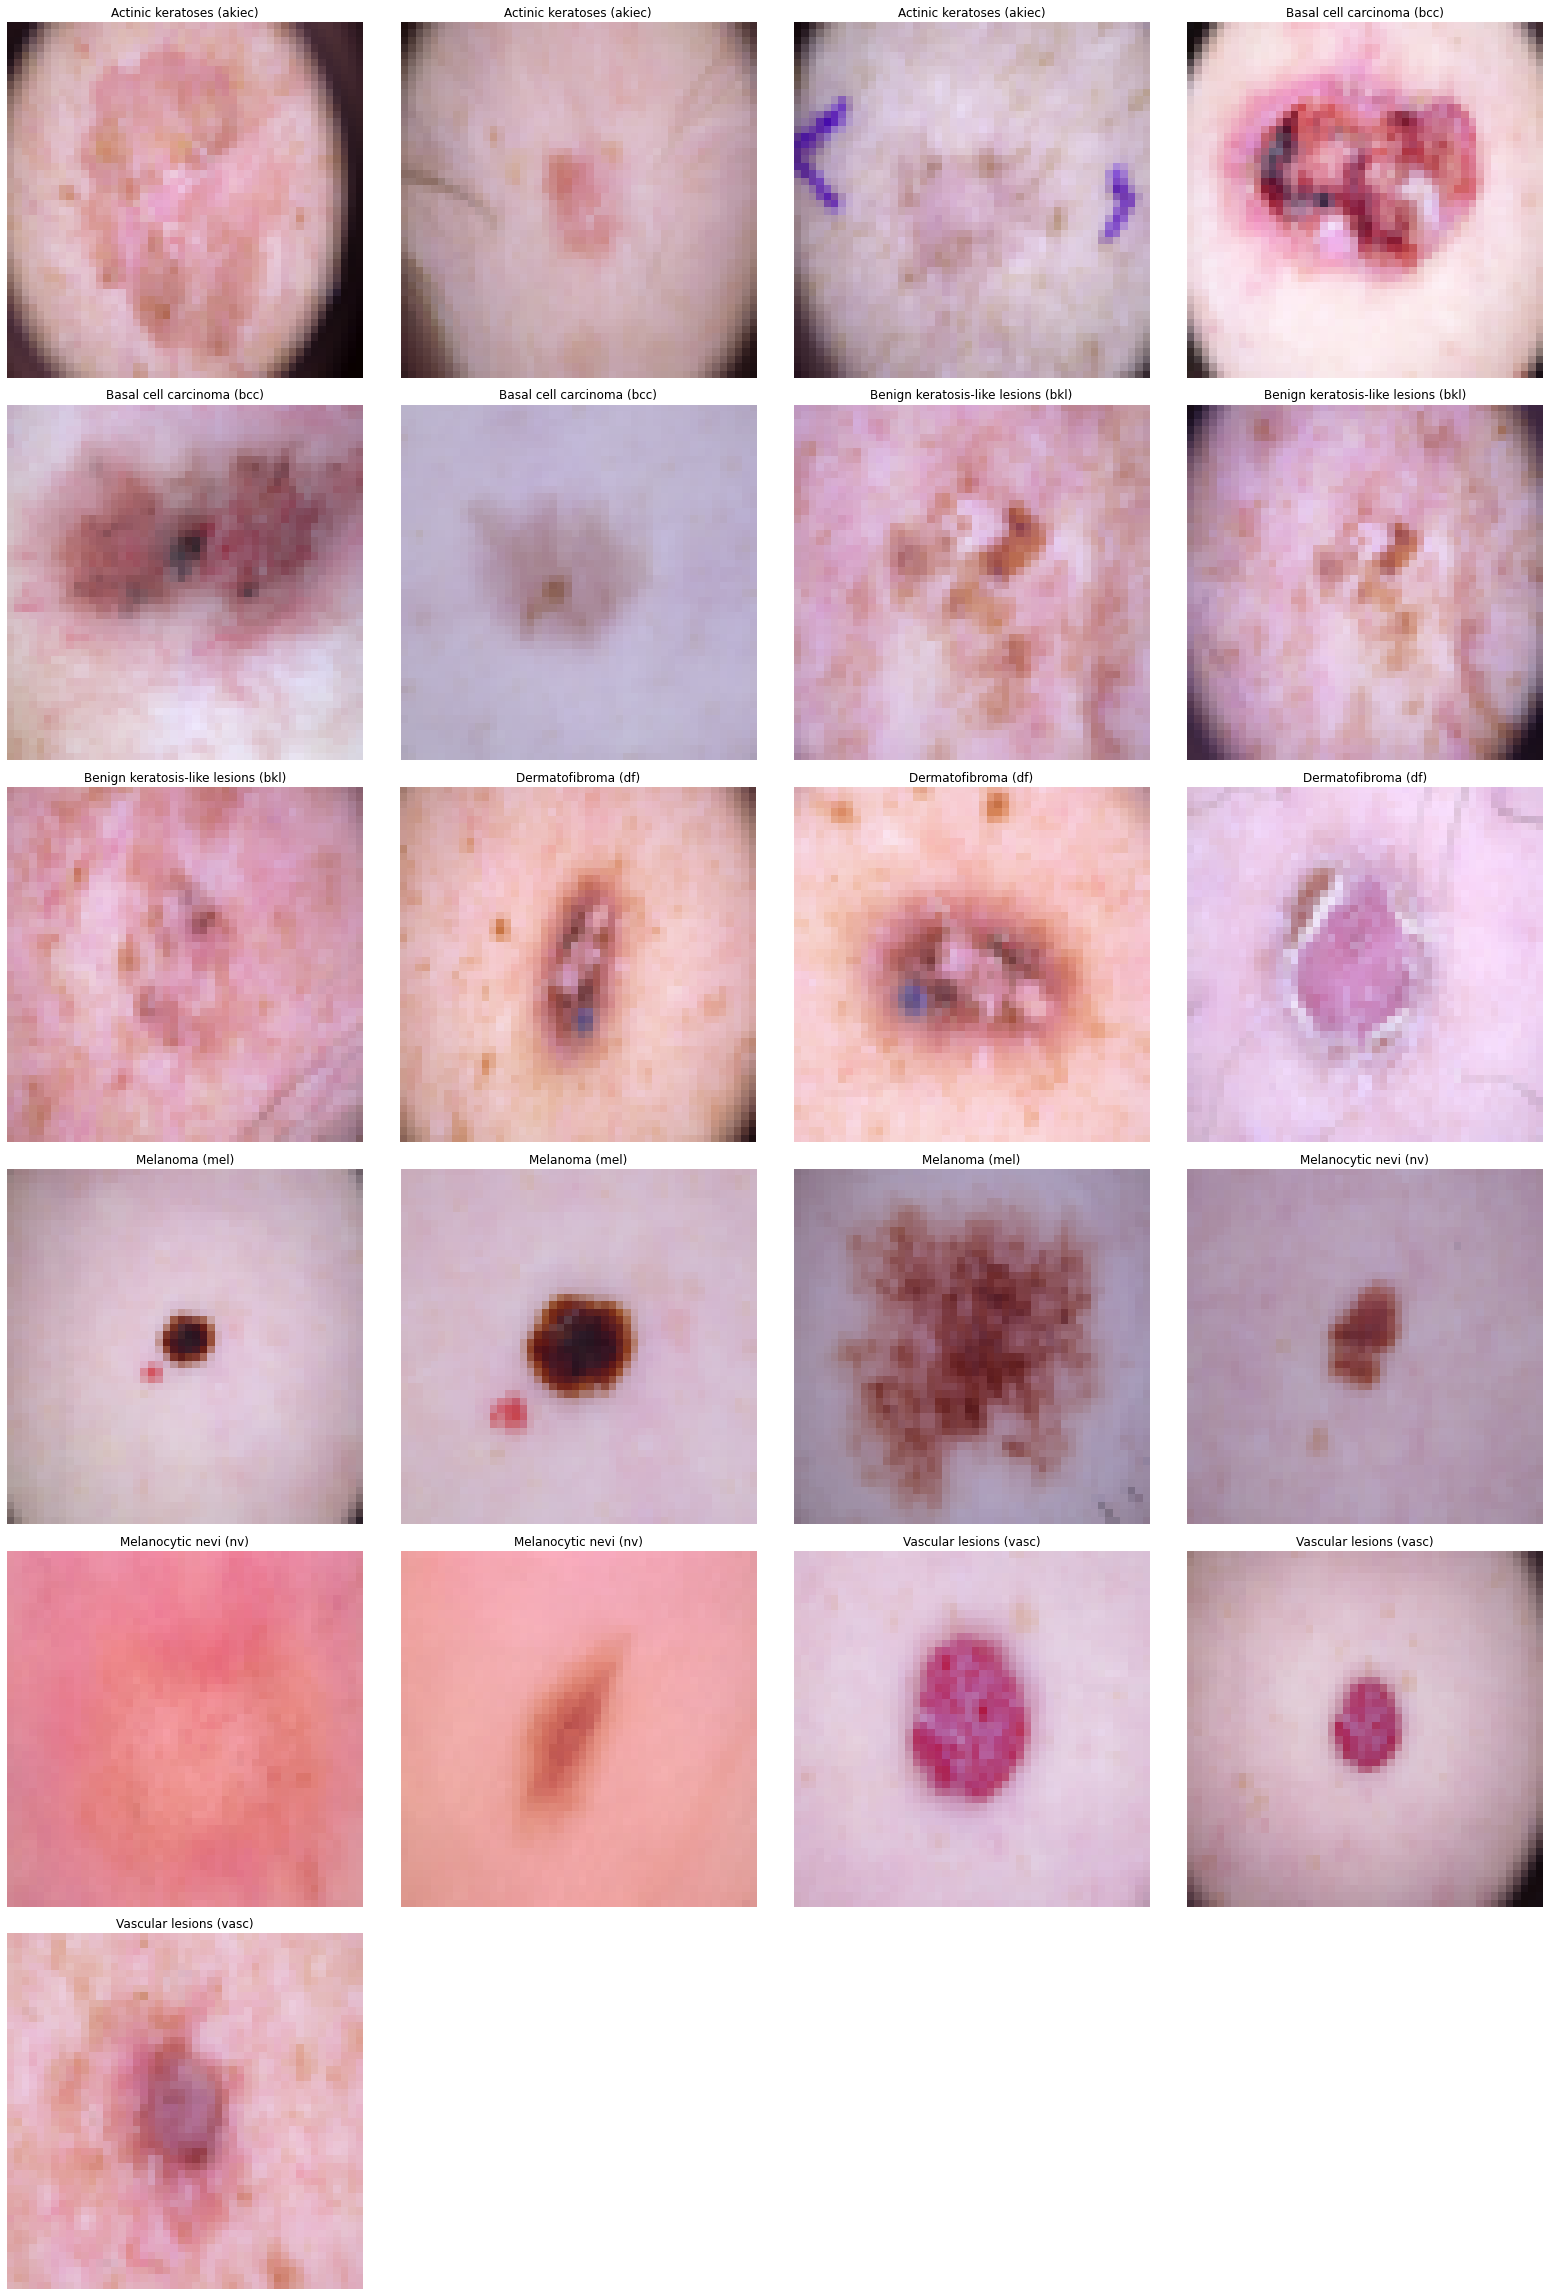

In [10]:
# Displaying 3 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:3, [9, 7]])

plt.figure(figsize=(22, 32))

# Adjust the number of subplots: 3 images per label, 7 labels -> 21 images total
for i in range(21):  # 7 labels x 3 images = 21 subplots
    plt.subplot(6, 4, i + 1)  # Adjusting the grid to 7 rows and 3 columns
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))  # Display image
    img_label = sample_data['cell_type'][i]  # Get the label for the image
    plt.title(img_label)  
    plt.axis("off")  

plt.tight_layout() 
plt.savefig('/kaggle/working/21skinimage.png', bbox_inches='tight', pad_inches=0) 
plt.show()

In [11]:
# Map 'dx' column to corresponding labels using reverse_label_mapping
data['label'] = data['dx'].map(reverse_label_mapping.get)

# Sort the data based on the 'label' column
data = data.sort_values('label')

# Reset the index after sorting (the previous index becomes irrelevant)
data = data.reset_index()

In [12]:
counter = 0  # Initialize a counter to keep track of the labels
frames = [data]  # Create a list of dataframes, starting with the original data

# Loop through the list of replication counts for each label
for i in [4, 4, 11, 17, 45, 52]:  # List represents how many times each label group should be replicated
    counter += 1  # Increment the counter to track the current label group

    # Find the indices of the rows with the current label (counter)
    index = data[data['label'] == counter].index.values

    # Select the rows corresponding to the current label group
    df_index = data.iloc[int(min(index)):int(max(index)+1)]

    # Replicate the selected label group 'i' times (based on the number in the list)
    df_index = df_index.append([df_index] * i, ignore_index=True)

    # Add the replicated dataframe to the list of frames
    frames.append(df_index)

In [13]:
len(frames)

7

In [14]:
balance_data = pd.concat(frames)

In [15]:
print(data.shape)
print(balance_data.shape)

(10015, 12)
(45756, 12)


In [16]:
# count total samples for each class
print(balance_data['label'].value_counts())

0    6705
3    6682
1    6678
5    6674
2    6594
4    6213
6    6210
Name: label, dtype: int64


In [17]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 48, 48, 3)
(10015, 1)


In [18]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = balance_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(balance_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 48, 48, 3)
(45756, 1)


# prepare train test splits

In [53]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 90,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  fill_mode = 'nearest',
                                  horizontal_flip = True)
                                  #vertical_flip = True,
                                  #fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test



In [54]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [55]:
# For new large Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

# Prepare model

## Analyse to get best dropout

In [115]:
def create_model(dropout_rate=0.0):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(48, 48, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  
    
    # Second Convolutional Layer
    model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')) 
    
    # Third Convolutional Layer
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))  
    
    # Fourth Convolutional Layer
    model.add(Conv2D(40, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))  

    # Fifth Convolutional Layer
    model.add(Conv2D(48, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # sixth Convolutional Layer
    model.add(Conv2D(56, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    model.add(Flatten())
    
    model.add(Dense(56, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


In [116]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
dropout_acc_scores = []

for rate in dropout_rates:
    model = create_model(dropout_rate=rate)
    history = model.fit(X_train_aug, Y_train_aug, validation_data=(X_test_aug, Y_test_aug), epochs=10, batch_size=64, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    dropout_acc_scores.append(val_acc)


<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Accuracy vs Dropout Rate')

Text(0.5, 0, 'Dropout Rate')

Text(0, 0.5, 'Validation Accuracy')

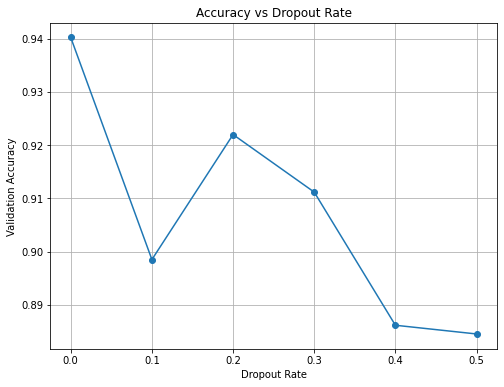

In [117]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(dropout_rates, dropout_acc_scores, marker='o')
plt.title('Accuracy vs Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.savefig('/kaggle/working/acc_vs_dropout.png', bbox_inches='tight', pad_inches=0)
plt.show()

## Analyse to get best Optimizers

In [118]:

def create_model(optimizer_name='adam'):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(48, 48, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  
    
    # Second Convolutional Layer
    model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')) 
    
    # Third Convolutional Layer
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))  
    
    # Fourth Convolutional Layer
    model.add(Conv2D(40, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))  

    # Fifth Convolutional Layer
    model.add(Conv2D(48, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # sixth Convolutional Layer
    model.add(Conv2D(56, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    model.add(Flatten())
    
    model.add(Dense(56, activation = 'relu'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.0))
    
    model.add(Dense(7, activation='softmax'))
    
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


<Figure size 576x432 with 0 Axes>

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'Accuracy vs Optimizers')

Text(0.5, 0, 'Optimizers')

Text(0, 0.5, 'Validation Accuracy')

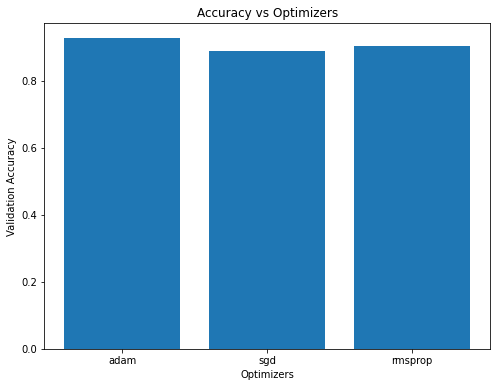

In [119]:
optimizers = ['adam', 'sgd', 'rmsprop']
optimizer_acc_scores = []

for opt in optimizers:
    model = create_model(optimizer_name=opt)
    history = model.fit(X_train_aug, Y_train_aug, validation_data=(X_test_aug, Y_test_aug), epochs=10, batch_size=64, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    optimizer_acc_scores.append(val_acc)

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(optimizers, optimizer_acc_scores)
plt.title('Accuracy vs Optimizers')
plt.xlabel('Optimizers')
plt.ylabel('Validation Accuracy')
plt.savefig('/kaggle/working/acc_vs_opt.png', bbox_inches='tight', pad_inches=0)
plt.show()


## Main model with best dropout and optimizers

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf

def create_model():
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(48, 48, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  
    
    # Second Convolutional Layer
    model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')) 
    
    # Third Convolutional Layer
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))  
    
    # Fourth Convolutional Layer
    model.add(Conv2D(40, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))  

    # Fifth Convolutional Layer
    model.add(Conv2D(48, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # sixth Convolutional Layer
    model.add(Conv2D(56, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    
    # Flatten the output from the convolutional layers
    model.add(Flatten())
    
    # Fully Connected Layers
    
    model.add(Dense(56, activation='relu'))
    model.add(Dense(32, activation='relu'))
    
    # Output Layer
    model.add(Dense(7, activation='softmax'))
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Display model summary
    model.summary()
    
    return model



In [101]:
model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 24)        3480      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        6944      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 40)          1

## Analyse to get best batch size

In [122]:
def train_model_with_batch_size(batch_size):
    #model = create_model()  # use your original or modified create_model
    history = model.fit(X_train_aug, Y_train_aug, validation_split=0.2, batch_size=batch_size, epochs=10, verbose=0)
    return history.history['val_accuracy'][-1]


<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Accuracy vs Batch Size')

Text(0.5, 0, 'Batch Size')

Text(0, 0.5, 'Validation Accuracy')

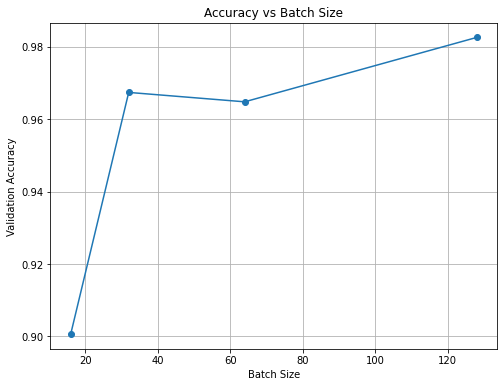

In [123]:
batch_sizes = [16, 32, 64, 128]
batch_acc_scores = []

for size in batch_sizes:
    val_acc = train_model_with_batch_size(batch_size=size)
    batch_acc_scores.append(val_acc)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes, batch_acc_scores, marker='o')
plt.title('Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.savefig('/kaggle/working/acc_vs_batchsize.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [68]:
model = create_model()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 24, 24, 24)        3480      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 12, 12, 24)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 12, 12, 32)        6944      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 6, 6, 40)         

# prepare the training plan

In [58]:
def train_model(model, X_train, Y_train, EPOCHS):
    
    Callbacks = [
    ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=0.00000000001)]
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 128,
                        epochs = EPOCHS,
                        callbacks = Callbacks)
    return history

In [59]:
aug_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
229/229 [==============================] - 2s 7ms/step - loss: 1.5811 - accuracy: 0.3859 - val_loss: 1.1518 - val_accuracy: 0.5539

Epoch 00001: val_loss improved from inf to 1.15176, saving model to .mdl_wts.hdf5
Epoch 2/50
229/229 [==============================] - 1s 6ms/step - loss: 0.9892 - accuracy: 0.6239 - val_loss: 0.8422 - val_accuracy: 0.6869

Epoch 00002: val_loss improved from 1.15176 to 0.84216, saving model to .mdl_wts.hdf5
Epoch 3/50
229/229 [==============================] - 1s 6ms/step - loss: 0.7110 - accuracy: 0.7304 - val_loss: 0.6064 - val_accuracy: 0.7698

Epoch 00003: val_loss improved from 0.84216 to 0.60641, saving model to .mdl_wts.hdf5
Epoch 4/50
229/229 [==============================] - 1s 6ms/step - loss: 0.5814 - accuracy: 0.7800 - val_loss: 0.5877 - val_accuracy: 0.7682

Epoch 00004: val_loss improved from 0.60641 to 0.58767, saving model to .mdl_wts.hdf5
Epoch 5/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4485 - accur

In [88]:
from tensorflow.keras.models import load_model

loaded_model1 = load_model('.mdl_wts.hdf5')
model.save('/kaggle/working/main_model_v3.h5')

In [61]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model1 = load_model('/kaggle/input/modelv3/other/default/1/main_model_v3.h5')

# test the model

In [25]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values(), digits=4)
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 
    

Test Accuracy: 98.252%
              precision    recall  f1-score   support

          nv     0.9889    0.8975    0.9410      1385
         mel     0.9516    0.9925    0.9716      1328
         bkl     0.9554    0.9938    0.9742      1294
         bcc     0.9947    1.0000    0.9974      1325
       akiec     0.9984    1.0000    0.9992      1270
        vasc     0.9985    1.0000    0.9992      1293
          df     0.9937    1.0000    0.9968      1257

    accuracy                         0.9825      9152
   macro avg     0.9830    0.9834    0.9828      9152
weighted avg     0.9829    0.9825    0.9823      9152



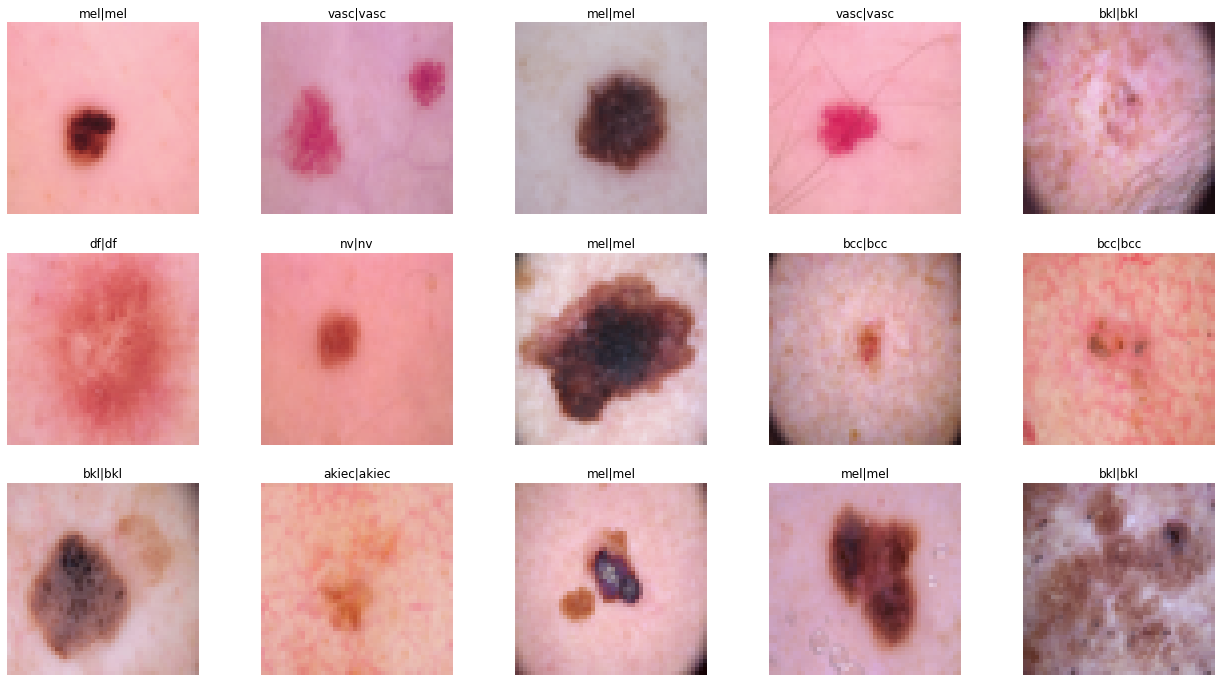

In [62]:
test_model(loaded_model1, X_test_aug, Y_test_aug)


# Training curves plot

In [89]:
def plot_model_training_curve_matplotlib(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.savefig('/kaggle/working/aug_train_history.png', bbox_inches='tight', pad_inches=0)
    plt.show()


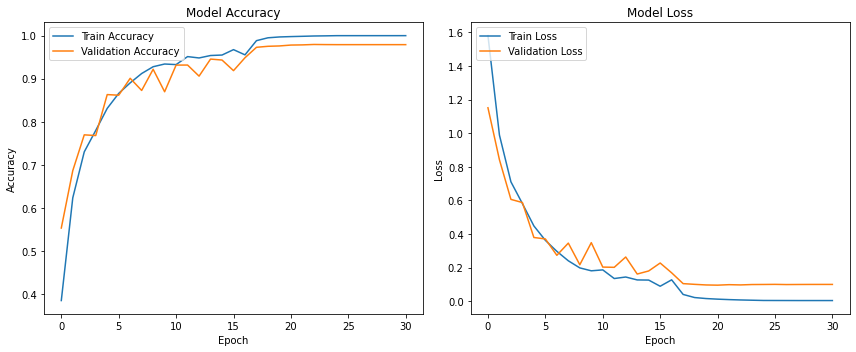

In [106]:
plot_model_training_curve_matplotlib(aug_history)

# Confusion matrix for multi-class

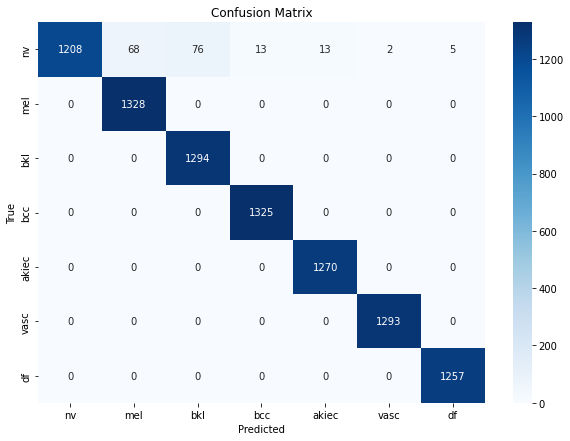

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('/kaggle/working/confusion_matrix_augtrain.png', bbox_inches='tight', pad_inches=0)
    plt.show()

# Get the true labels and predicted labels for the test set
y_true = np.array(Y_test_aug)
y_pred = model.predict(X_test_aug)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, list(label_mapping.values()))

## ROC Curve

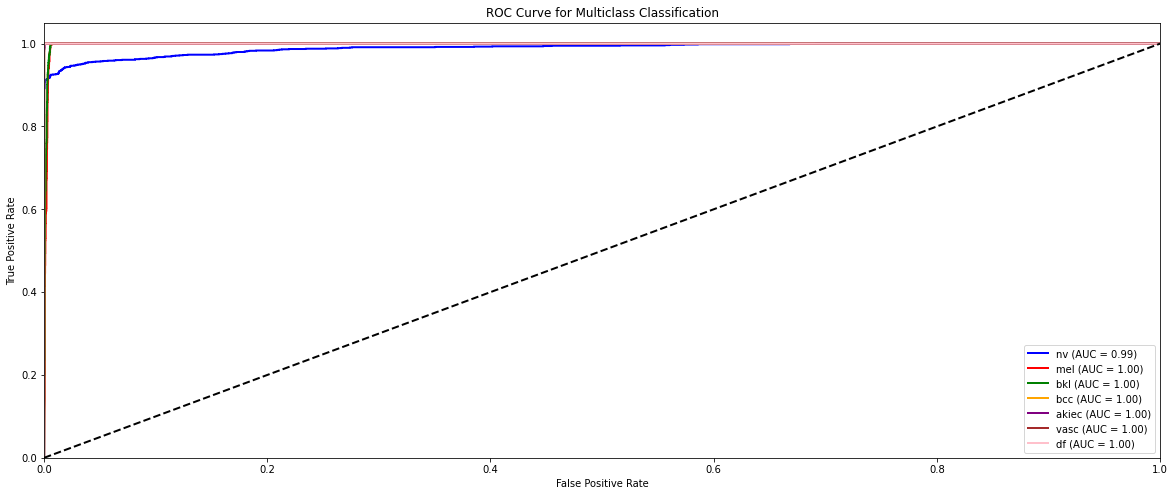

In [92]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_roc_curve(X_test, Y_test, model, n_classes):
    # Binarize the output labels (one-hot encode the labels for ROC computation)
    y_test_bin = label_binarize(Y_test, classes=list(range(n_classes)))
    
    # Predict probabilities
    y_score = model.predict(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(20, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0} (AUC = {1:0.2f})'.format(list(label_mapping.values())[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc='lower right')
    plt.savefig('/kaggle/working/ROC_Curve_augtrain.png', bbox_inches='tight', pad_inches=0)
    plt.show()

# Plot the ROC curve for the test set
n_classes = len(label_mapping)
plot_roc_curve(X_test_aug, Y_test_aug, model, n_classes)


Predicted labels: [1 5 1 ... 4 2 2]
True labels: [1 5 1 ... 4 2 2]


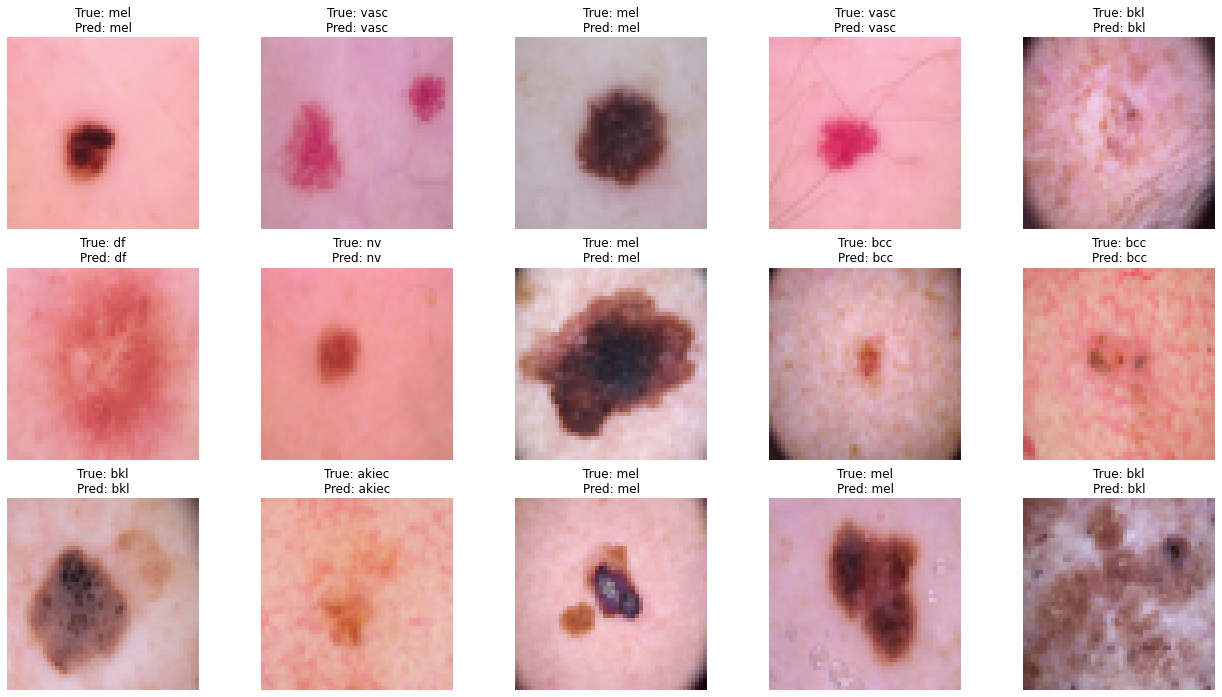

<Figure size 432x288 with 0 Axes>

In [93]:
def predict_and_display_results(X_test, Y_test, model):
    # Make predictions
    y_pred_prob = model.predict(X_test)  # Probabilities for each class
    y_pred = np.argmax(y_pred_prob, axis=1)  # Get the index of the highest probability (predicted class)
    
    # Get the true labels
    y_true = np.array(Y_test).flatten()

    # Display predictions and actual labels
    print("Predicted labels:", y_pred)
    print("True labels:", y_true)
    
    # Visualize some predictions
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title("True: " + label_mapping[y_true[i]] + "\nPred: " + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()
    plt.savefig('/kaggle/working/prediction_augtrain.png', bbox_inches='tight', pad_inches=0)

# Predict on the test set and display results
predict_and_display_results(X_test_aug, Y_test_aug, model)


# prunning

## Analysing to find maximum best pruning percentage without loosing too much accuracy

In [63]:
from tensorflow.keras.callbacks import Callback
import tensorflow_model_optimization as tfmot

# Function to apply weight pruning
def apply_weight_pruning(loaded_model1, pruning_percent):
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=pruning_percent / 100.0,
            begin_step=0,
            end_step=len(X_train_aug) // 128 * 10)  # Steps based on dataset size
    }
    
    # Apply pruning to the layers
    pruned_model = prune_low_magnitude(loaded_model1, **pruning_params)
    
    # Re-compile model after applying pruning
    pruned_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
    
    return pruned_model

# Function to train and evaluate pruned models
def evaluate_pruned_models(pruning_percent_list, X_train, Y_train, X_test, Y_test):
    original_model_acc = []
    weight_pruned_acc = []
    
    # Evaluate original model
    _, acc = loaded_model1.evaluate(X_test, Y_test, verbose=0)
    original_model_acc.append(acc)
    
    for percent in pruning_percent_list:
        print(f"\nPruning {percent}% of weights")
        
        # Weight pruning
        pruned_model_w = apply_weight_pruning(loaded_model1, percent)
        
        # Callback for pruning updates
        callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep(),
            tfmot.sparsity.keras.PruningSummaries(log_dir='/tmp/logs')
        ]
        
        pruned_model_w.fit(X_train, Y_train, epochs=3, verbose=0, callbacks=callbacks)
        _, acc_w = pruned_model_w.evaluate(X_test, Y_test, verbose=0)
        weight_pruned_acc.append(acc_w)
    
    return original_model_acc, weight_pruned_acc

# Define pruning percentages
pruning_percent_list = [0, 25, 40, 50, 60, 70, 80, 90, 99]

# Evaluate pruned models
original_acc, weight_pruned_acc = evaluate_pruned_models(pruning_percent_list, 
                                                         X_train_aug, Y_train_aug, 
                                                         X_test_aug, Y_test_aug)



Pruning 0% of weights

Pruning 25% of weights

Pruning 40% of weights

Pruning 50% of weights

Pruning 60% of weights

Pruning 70% of weights

Pruning 80% of weights

Pruning 90% of weights

Pruning 99% of weights


<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy after Weight Pruning')

Text(0.5, 0, 'Pruning Percentage')

Text(0, 0.5, 'Accuracy')

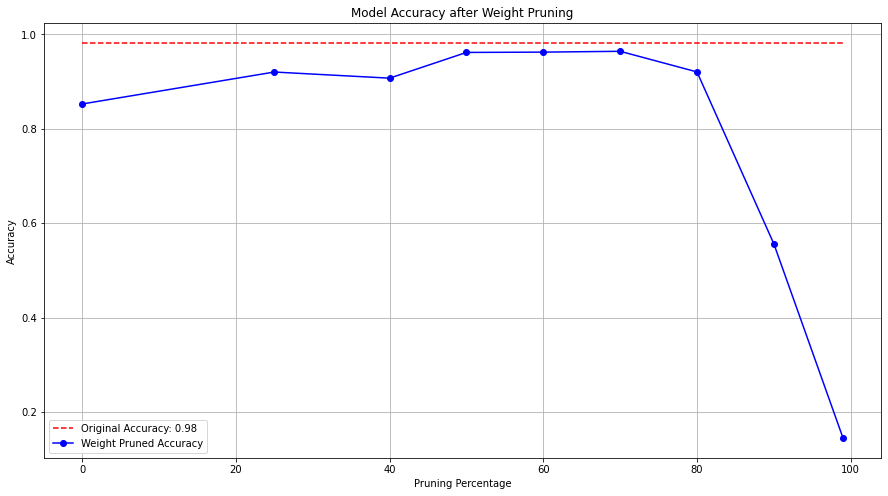

In [68]:
plt.figure(figsize=(15,8))

# Correctly scale the original accuracy
plt.plot(pruning_percent_list, [original_acc[0]]*len(pruning_percent_list), 'r--', label=f'Original Accuracy: {original_acc[0]:.2f}')

# Plot weight-pruned accuracies
plt.plot(pruning_percent_list, weight_pruned_acc, 'b-o', label='Weight Pruned Accuracy')

plt.title('Model Accuracy after Weight Pruning')
plt.xlabel('Pruning Percentage')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/prungraph2.png', bbox_inches='tight', pad_inches=0)
plt.show()


## Fine-tuning the pruned model:

In [102]:
def fine_tune_pruned_model(pruned_model, X_train, Y_train, X_test, Y_test, EPOCHS):
    callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tf.keras.callbacks.ModelCheckpoint('.mdl_wts3.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
    ]
    
    history = pruned_model.fit(X_train, Y_train, 
                               validation_split=0.2,
                               epochs=EPOCHS,
                               batch_size=128, 
                               callbacks=callbacks)
    
    pruned_model.evaluate(X_test, Y_test)
    return pruned_model, history
tf.keras.backend.clear_session()
# Fine-tune your pruned model at 50% pruning
pruned_model_50 = apply_weight_pruning(model, 50)
pruned_model_50, history = fine_tune_pruned_model(pruned_model_50, X_train_aug, Y_train_aug, X_test_aug, Y_test_aug, EPOCHS=100)


Epoch 1/100
229/229 [==============================] - 6s 12ms/step - loss: 1.5594 - accuracy: 0.3849 - val_loss: 1.1135 - val_accuracy: 0.5537

Epoch 00001: val_loss improved from inf to 1.11349, saving model to .mdl_wts3.hdf5
Epoch 2/100
229/229 [==============================] - 2s 10ms/step - loss: 0.9833 - accuracy: 0.6203 - val_loss: 0.8708 - val_accuracy: 0.6570

Epoch 00002: val_loss improved from 1.11349 to 0.87082, saving model to .mdl_wts3.hdf5
Epoch 3/100
229/229 [==============================] - 2s 10ms/step - loss: 0.7121 - accuracy: 0.7278 - val_loss: 0.6640 - val_accuracy: 0.7461

Epoch 00003: val_loss improved from 0.87082 to 0.66400, saving model to .mdl_wts3.hdf5
Epoch 4/100
229/229 [==============================] - 2s 10ms/step - loss: 0.5832 - accuracy: 0.7778 - val_loss: 0.6091 - val_accuracy: 0.7726

Epoch 00004: val_loss improved from 0.66400 to 0.60915, saving model to .mdl_wts3.hdf5
Epoch 5/100
229/229 [==============================] - 2s 11ms/step - loss: 

In [103]:
# Strip pruning wrappers to make the model ready for deployment
final_model = tfmot.sparsity.keras.strip_pruning(pruned_model_50)


In [79]:
final_model.save('/kaggle/working/Skin_Cancerpruned/pruned_model_v2.h5')

In [27]:
# Load the model
loaded_model2 = load_model('/kaggle/input/prunndv2/other/default/1/pruned_model_v2.h5')

In [104]:
final_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# Evaluate test accuracy of the pruned model
test_loss, test_accuracy = final_model.evaluate(X_test_aug, Y_test_aug, verbose=0)
print(f"Test Accuracy of 50% Pruned Model: {test_accuracy * 100:.2f}%")

Test Accuracy of 50% Pruned Model: 97.66%


In [78]:
final_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# Evaluate test accuracy of the pruned model
test_loss, test_accuracy = final_model.evaluate(X_test_aug, Y_test_aug, verbose=0)
print(f"Test Accuracy of 50% Pruned Model: {test_accuracy * 100:.2f}%")

Test Accuracy of 50% Pruned Model: 98.07%


Test Accuracy: 98.066%
              precision    recall  f1-score   support

          nv     1.0000    0.8722    0.9317      1385
         mel     0.9513    1.0000    0.9750      1328
         bkl     0.9445    1.0000    0.9715      1294
         bcc     0.9903    1.0000    0.9951      1325
       akiec     0.9899    1.0000    0.9949      1270
        vasc     0.9985    1.0000    0.9992      1293
          df     0.9960    1.0000    0.9980      1257

    accuracy                         0.9807      9152
   macro avg     0.9815    0.9817    0.9808      9152
weighted avg     0.9815    0.9807    0.9802      9152



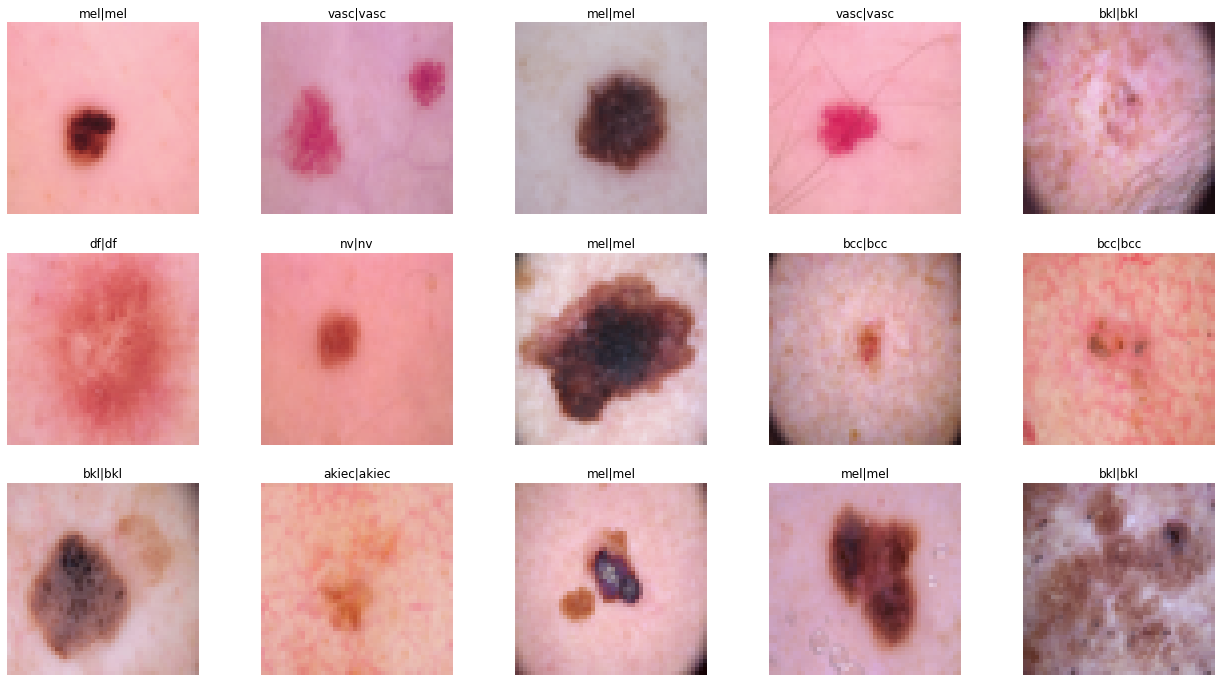

In [81]:
test_model(pruned_model_50, X_test_aug, Y_test_aug)

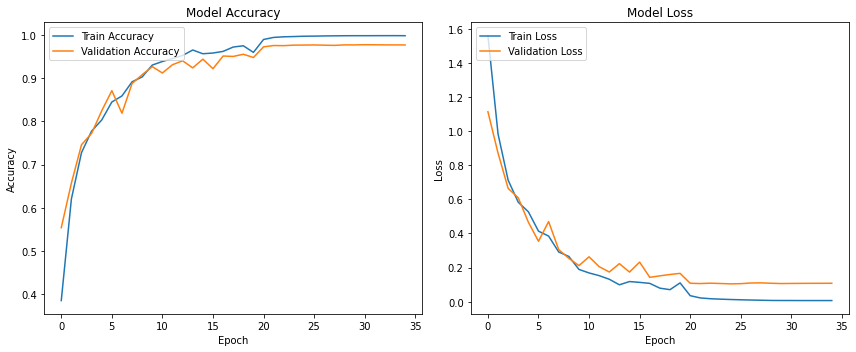

In [105]:
plot_model_training_curve_matplotlib(history)

### Compare model sizes

In [216]:
import os
original_size = os.path.getsize('/kaggle/working/main_model_v3.h5')
pruned_size = os.path.getsize('/kaggle/working/Skin_Cancerpruned/pruned_model_v2.h5')

print(f"Original Model Size: {original_size / 1e6:.2f} MB")
print(f"Pruned Model Size: {pruned_size / 1e6:.2f} MB")


Original Model Size: 1.31 MB
Pruned Model Size: 0.45 MB


## Model inference time

In [85]:
import time

# Measure inference time for a single sample
def measure_inference_time(model, X_test):
    start_time = time.time()
    model.predict(X_test[:1])  # Predict on a single test sample
    end_time = time.time()
    
    inference_time = end_time - start_time
    print(f"Inference Time for 1 sample: {inference_time:.6f} seconds")
    return inference_time

# Measure time for the pruned model
print("Pruned Model Inference Time:")
pruned_inference_time = measure_inference_time(final_model, X_test_aug)

# Measure time for the original model
print("\nOriginal Model Inference Time:")
original_inference_time = measure_inference_time(model, X_test_aug)

# Compare inference times
print(f"\nPruned model is {original_inference_time / pruned_inference_time:.2f}x faster than the original model.")


Pruned Model Inference Time:
Inference Time for 1 sample: 0.039537 seconds

Original Model Inference Time:
Inference Time for 1 sample: 0.042873 seconds

Pruned model is 1.08x faster than the original model.


In [84]:
import numpy as np
import tensorflow_model_optimization as tfmot

def calculate_pruned_parameters(model):
    # Get the total number of parameters in the original model
    total_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    
    # Assuming 50% pruning
    pruned_params = total_params * 0.50
    
    print(f"Total trainable parameters before pruning: {total_params}")
    print(f"Number of pruned parameters (50% pruning): {int(pruned_params)}")
    print(f"Number of remaining parameters after pruning: {int(total_params - pruned_params)}")

# Use this function after creating the pruned model
calculate_pruned_parameters(loaded_model2)


Total trainable parameters before pruning: 101511
Number of pruned parameters (50% pruning): 50755
Number of remaining parameters after pruning: 50755


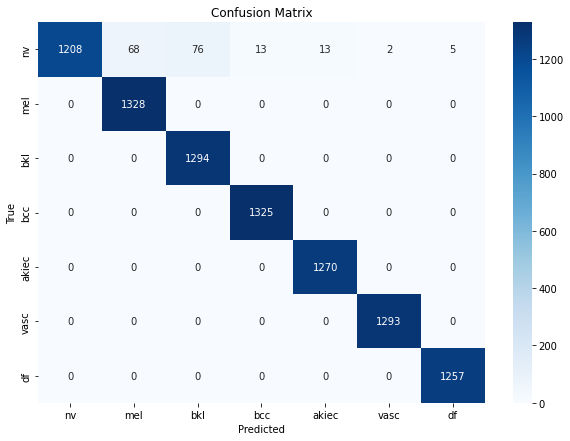

In [95]:
# Get the true labels and predicted labels for the pruned model on the test set
y_true_pruned = np.array(Y_test_aug)
y_pred_pruned = pruned_model_50.predict(X_test_aug)
y_pred_pruned = np.array(list(map(lambda x: np.argmax(x), y_pred_pruned)))

# Plot the confusion matrix for pruned model
plot_confusion_matrix(y_true_pruned, y_pred_pruned, list(label_mapping.values()))


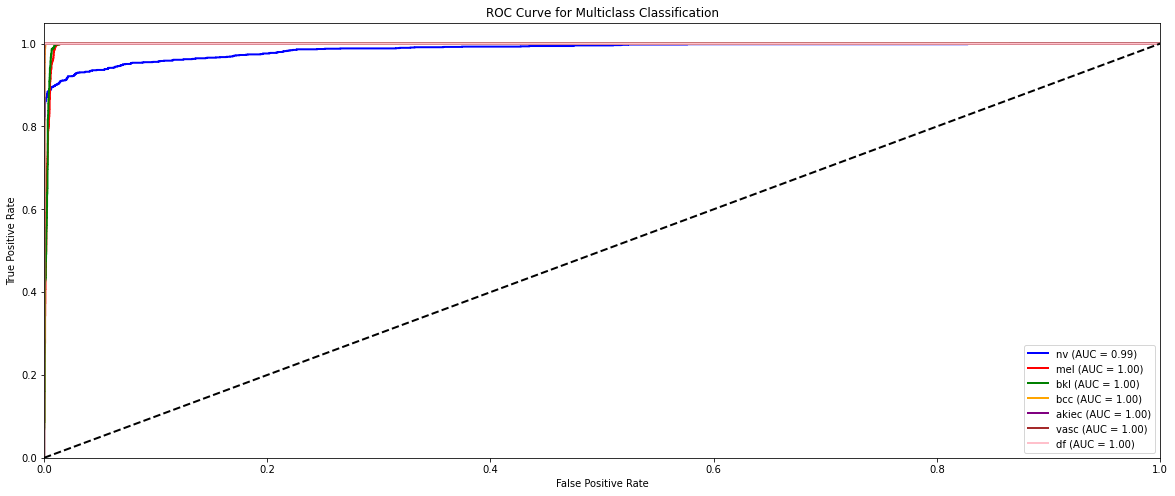

In [265]:
# Plot the ROC curve for pruned model on the test set
plot_roc_curve(X_test_aug, Y_test_aug, pruned_model_50, n_classes)

Predicted labels: [1 5 1 ... 4 2 2]
True labels: [1 5 1 ... 4 2 2]


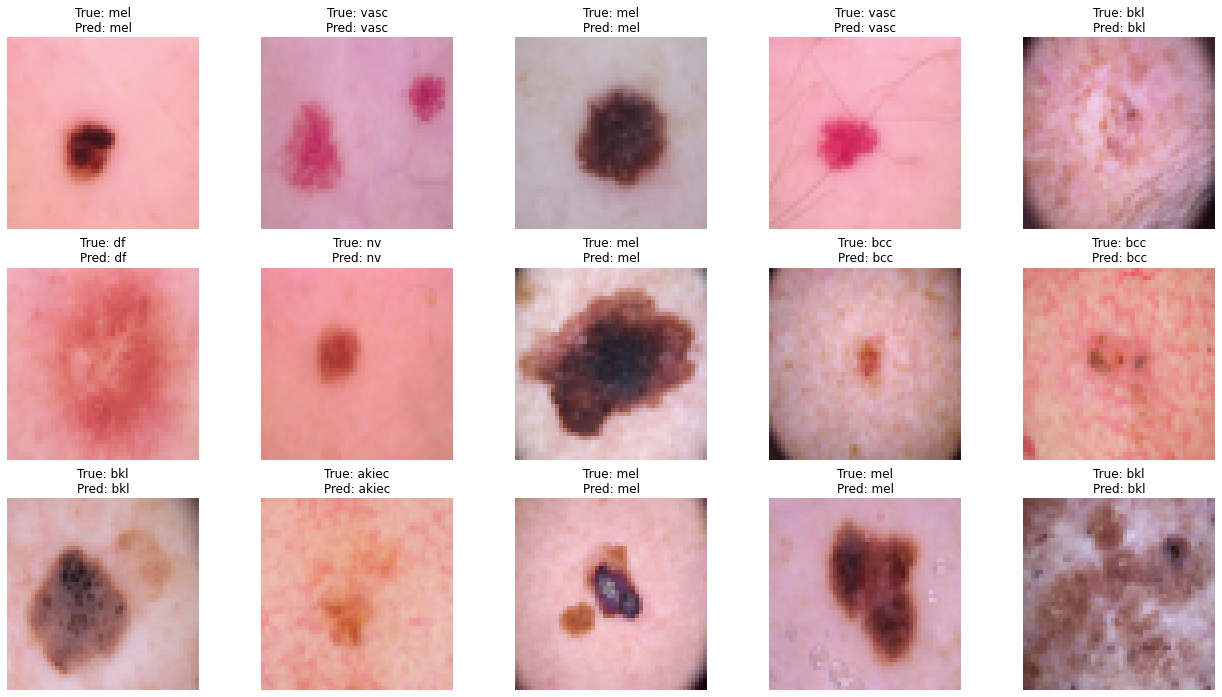

<Figure size 432x288 with 0 Axes>

In [266]:
# Predict and display results for pruned model
predict_and_display_results(X_test_aug, Y_test_aug, pruned_model_50)

# Grad-Cam ++

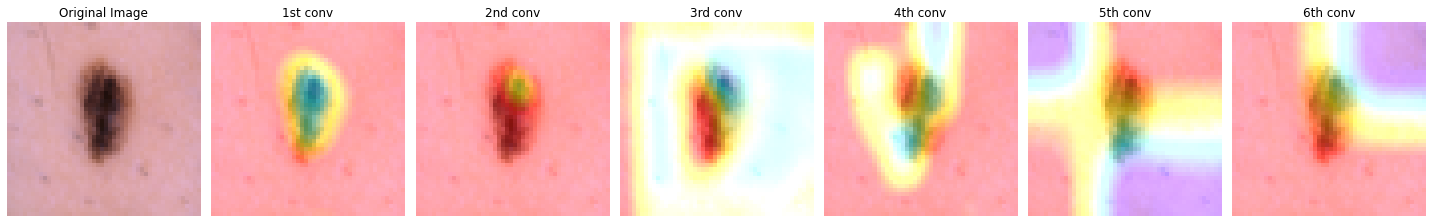

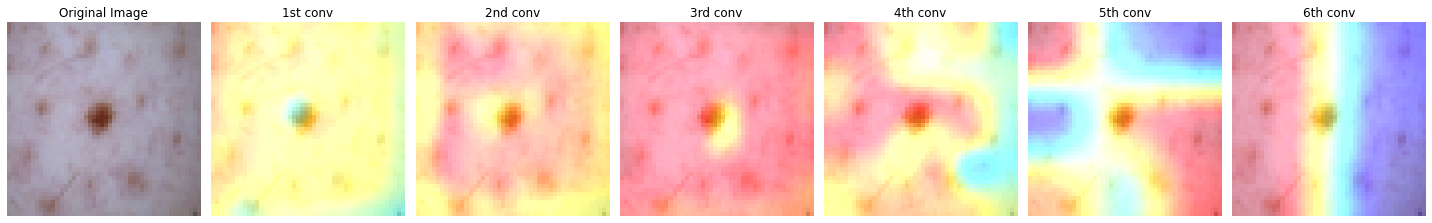

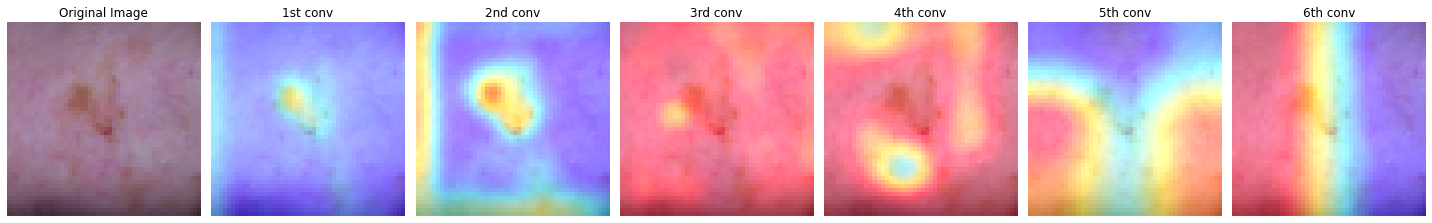

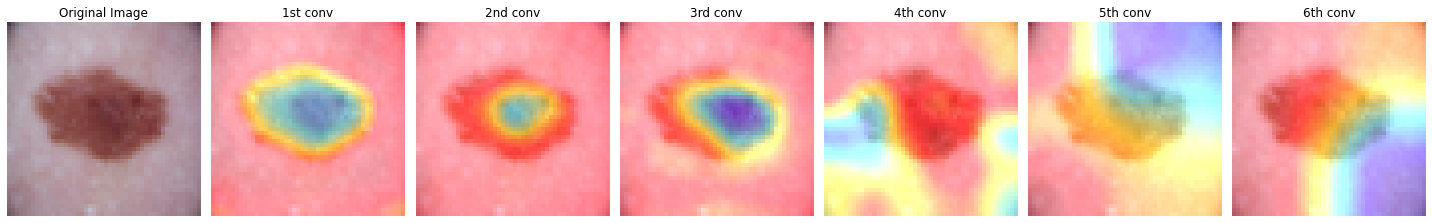

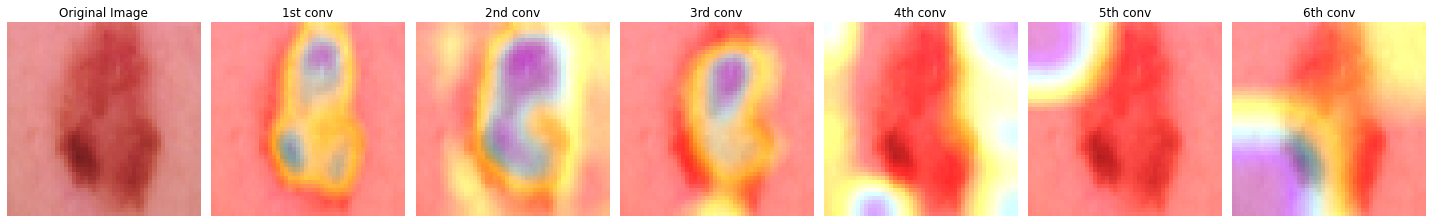

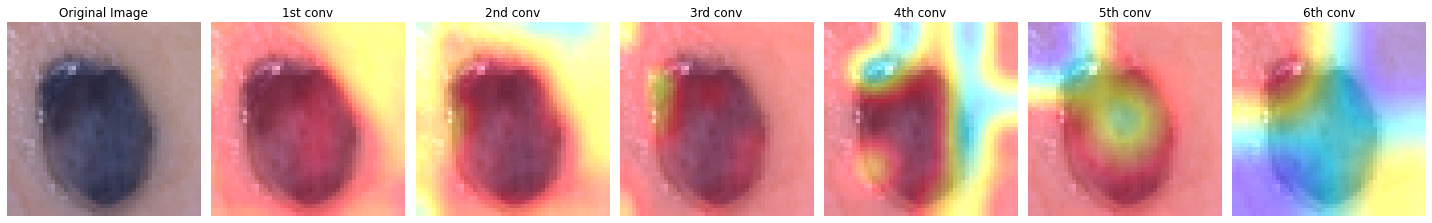

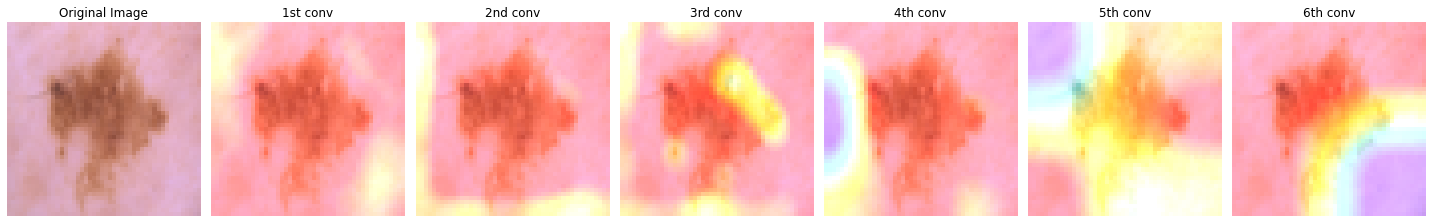

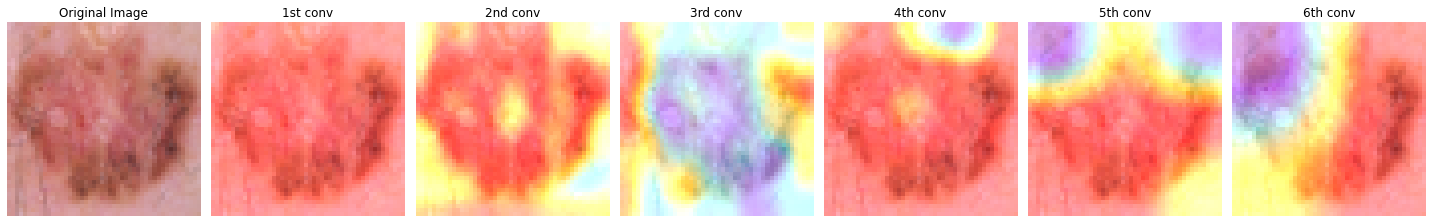

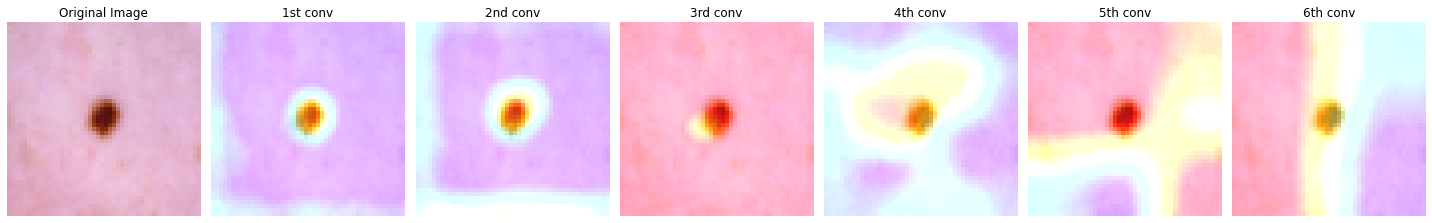

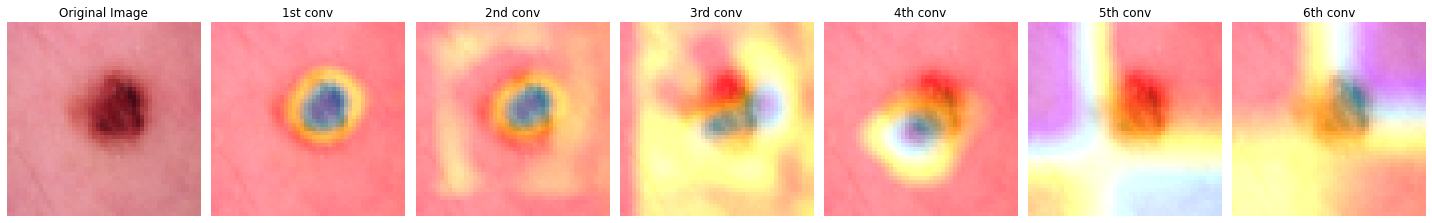

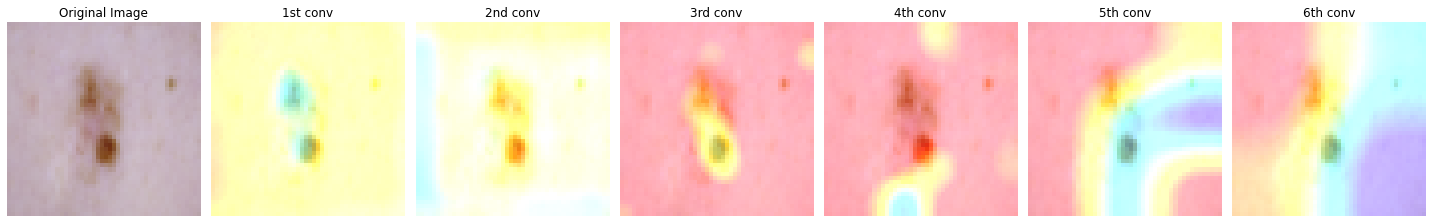

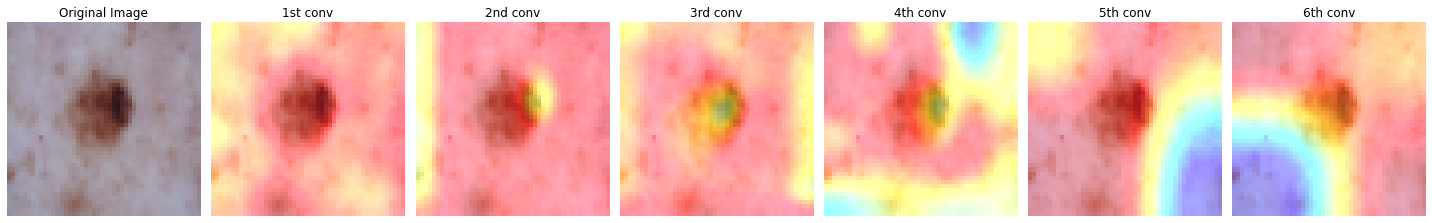

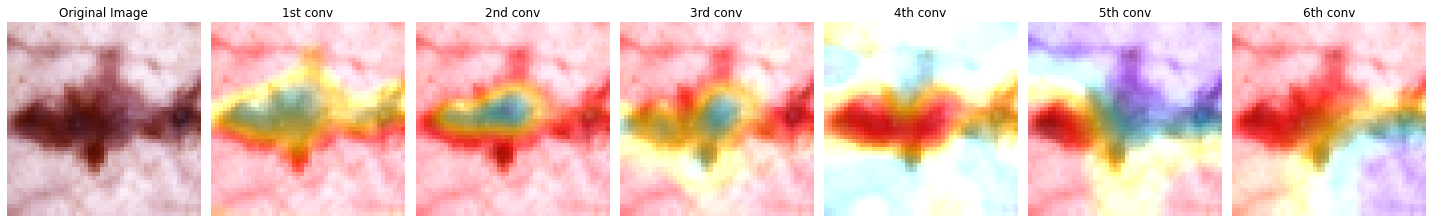

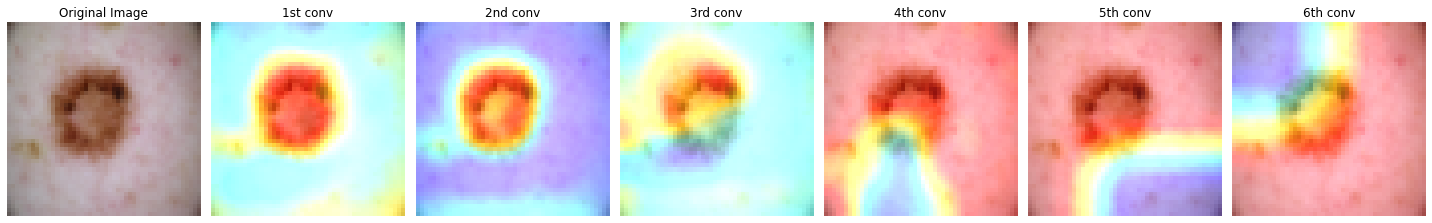

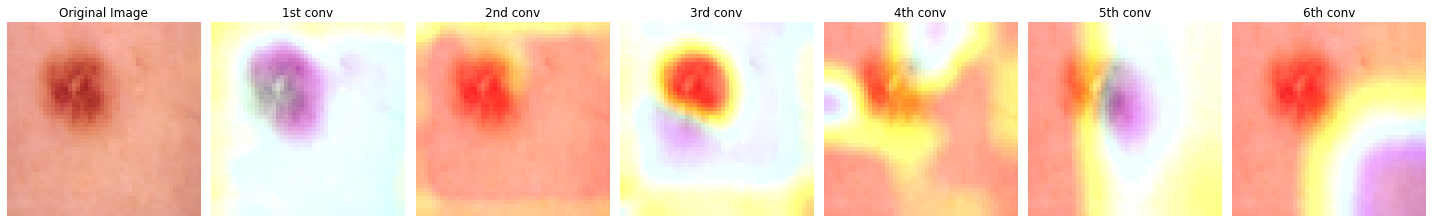

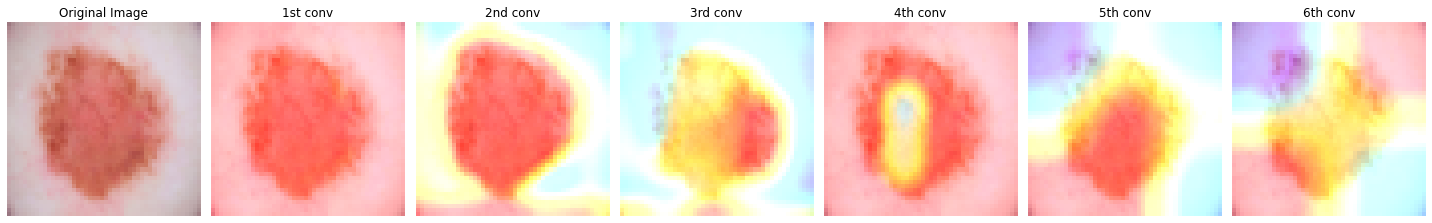

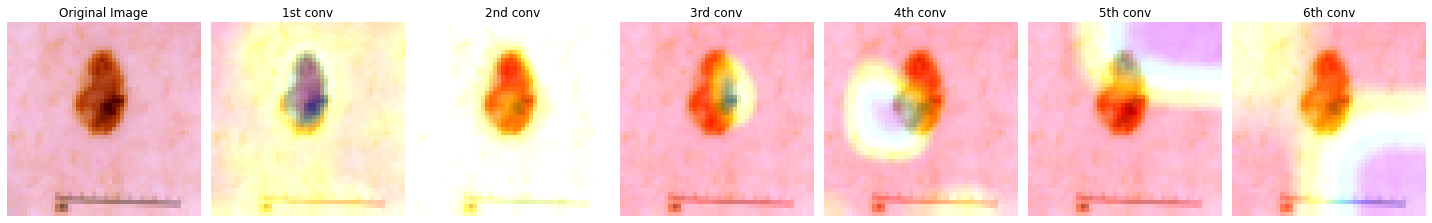

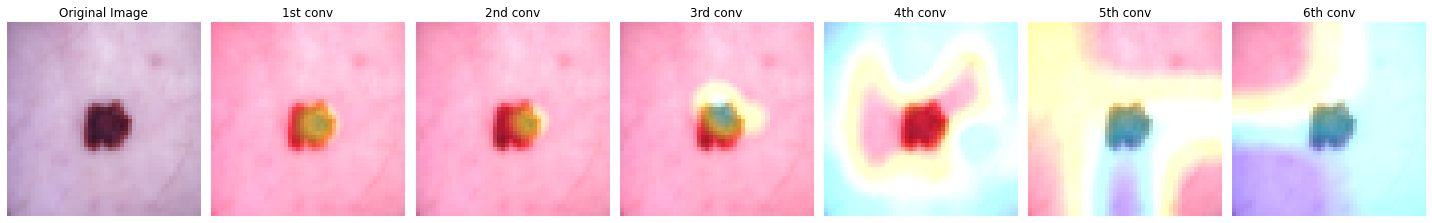

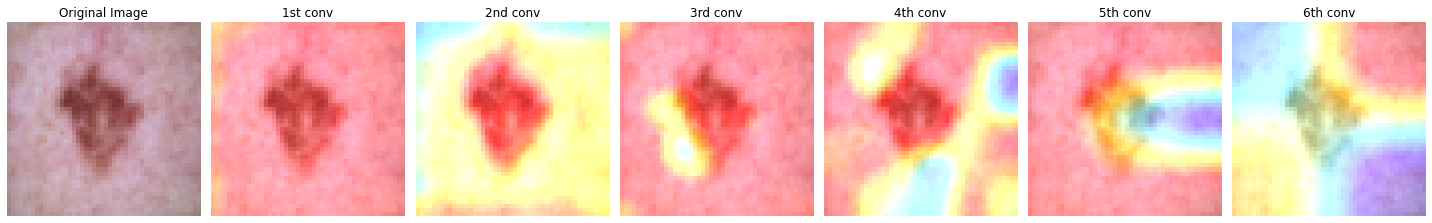

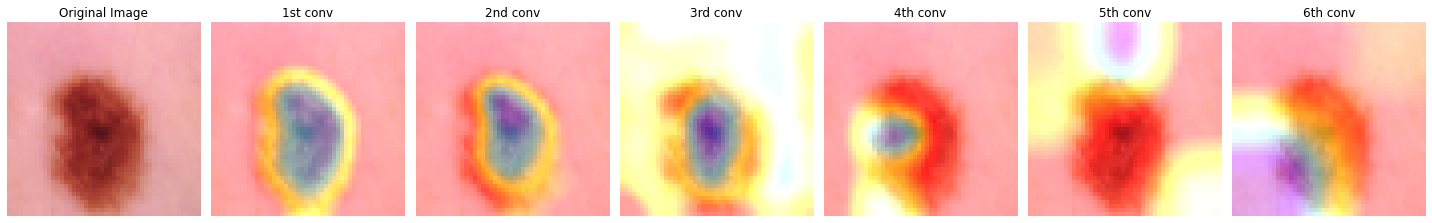

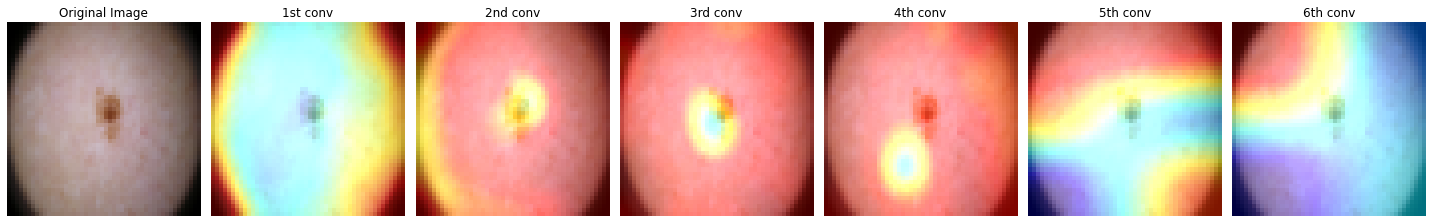

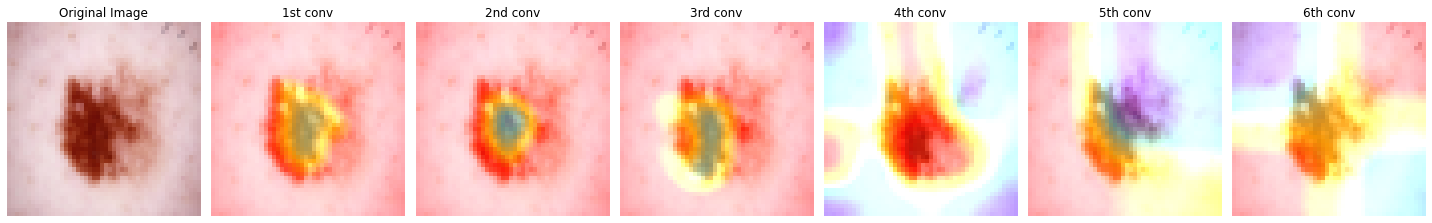

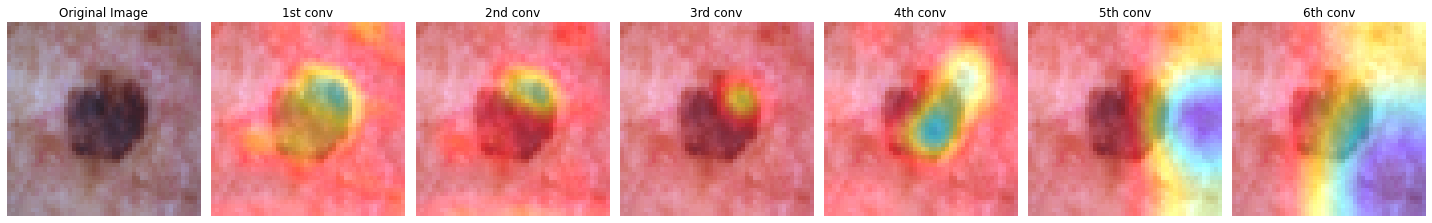

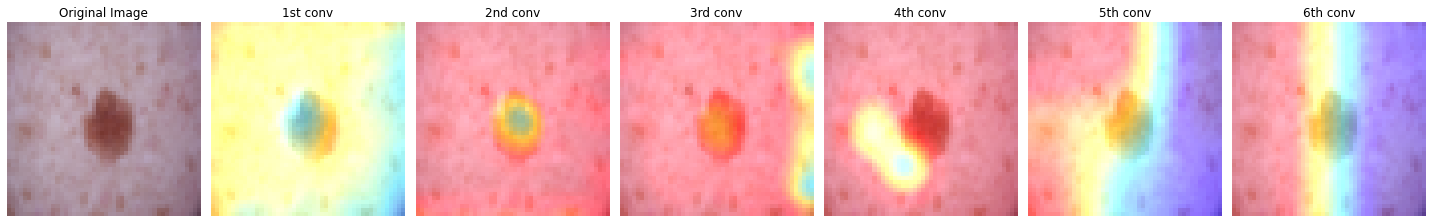

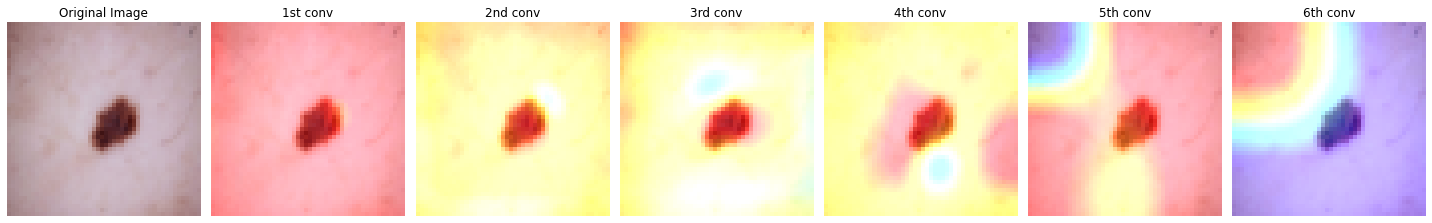

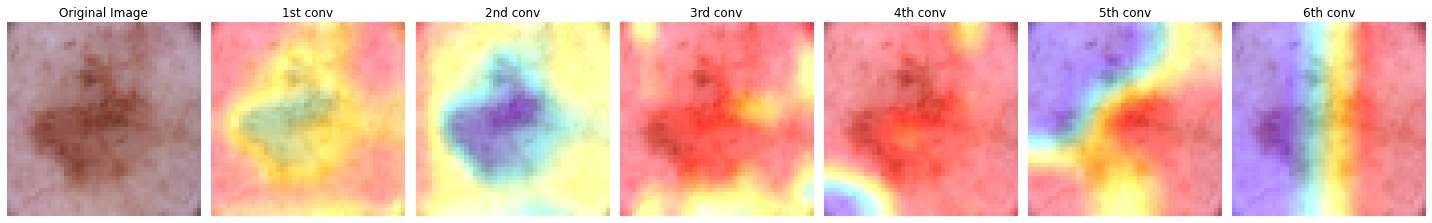

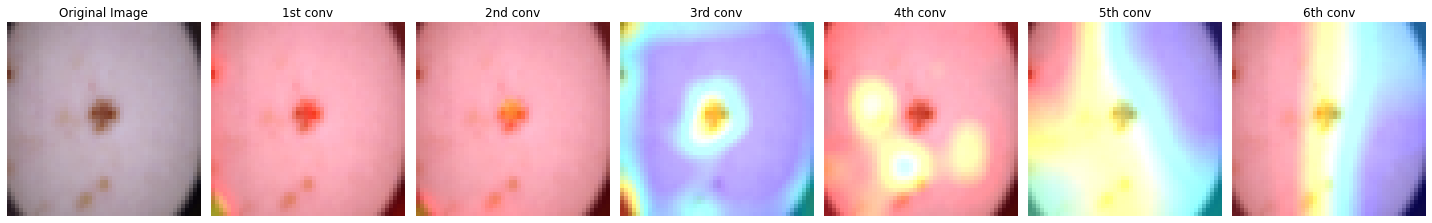

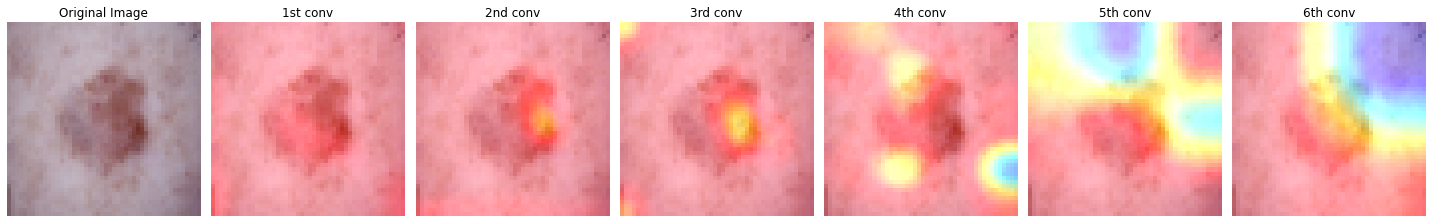

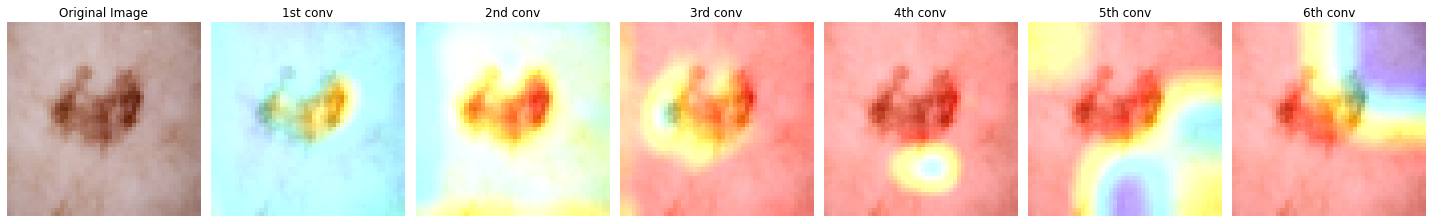

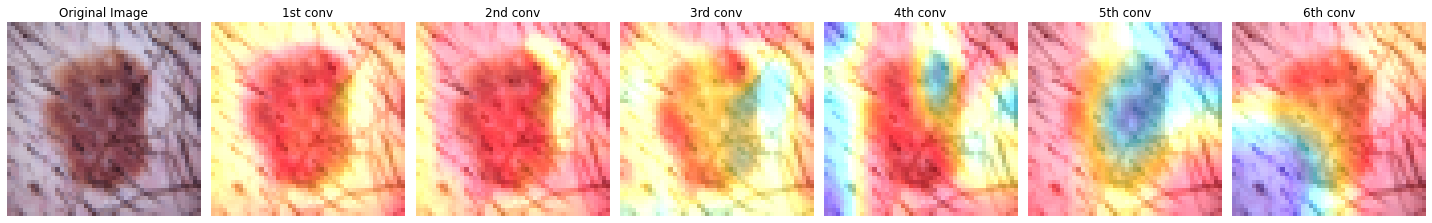

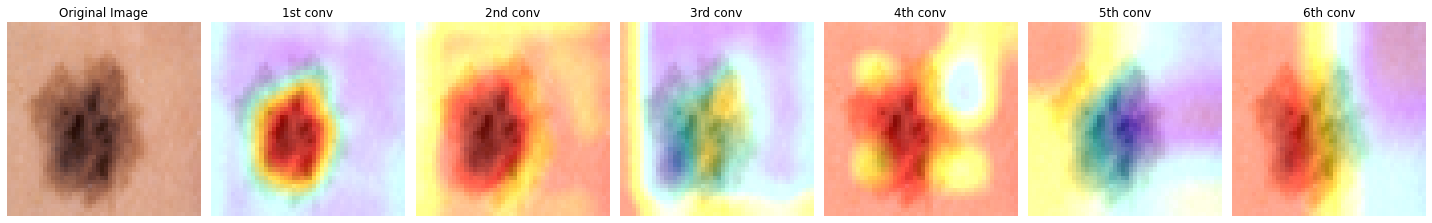

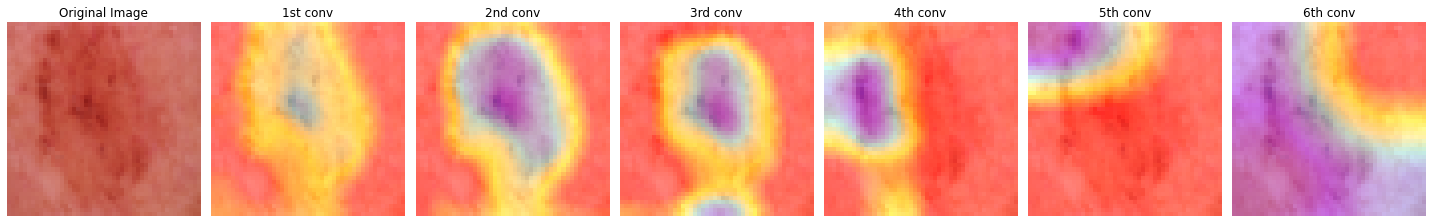

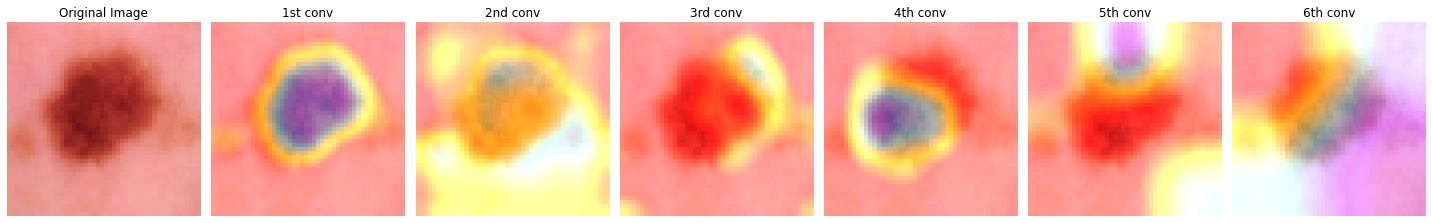

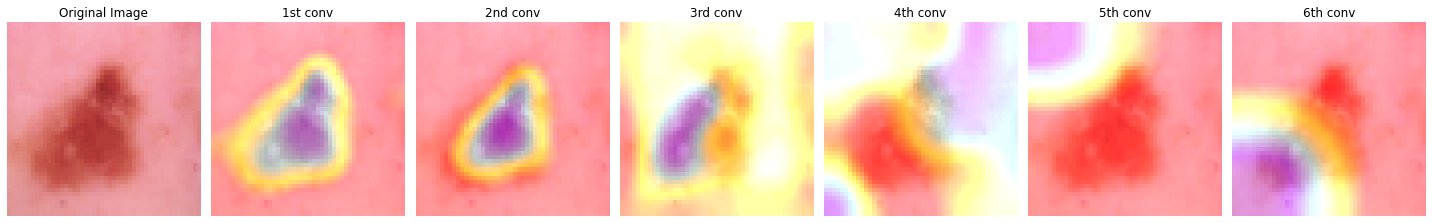

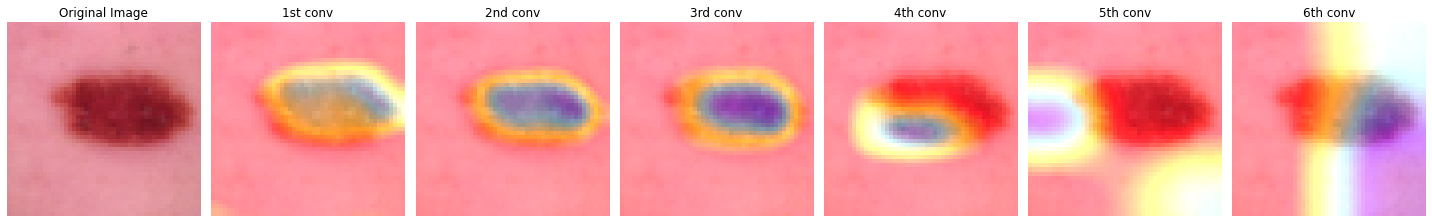

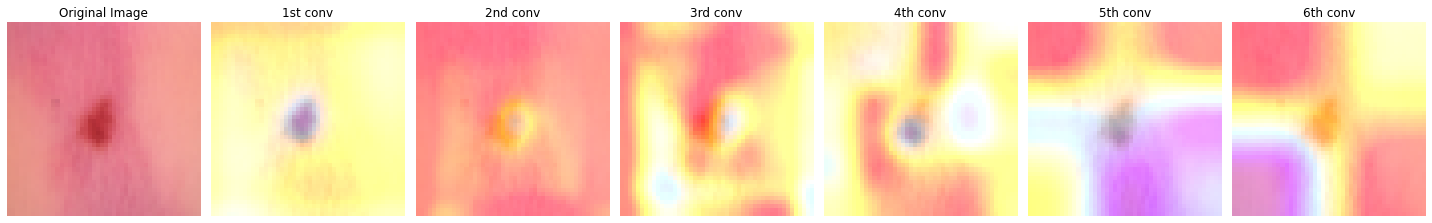

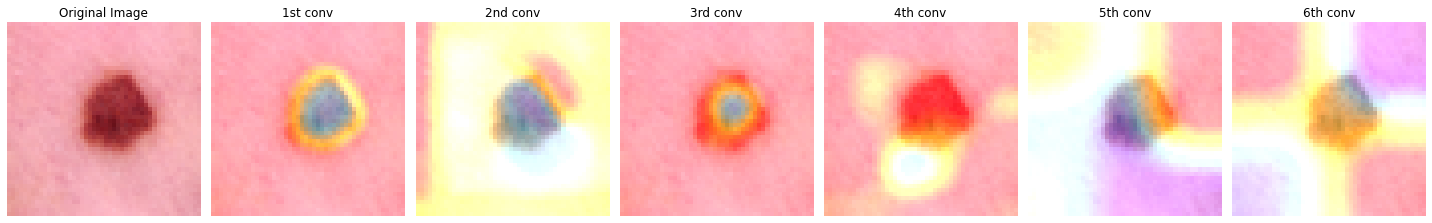

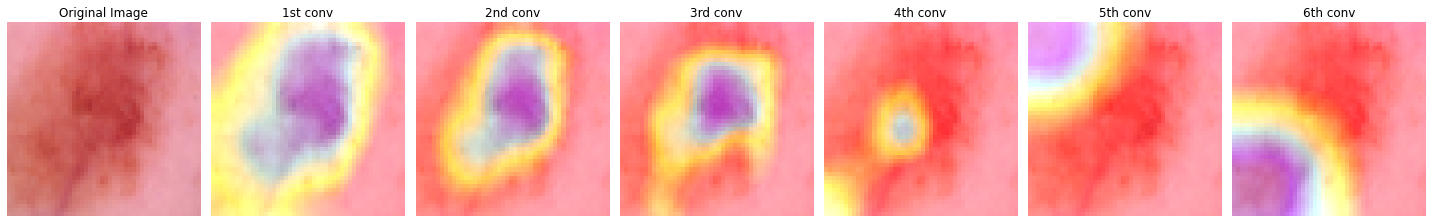

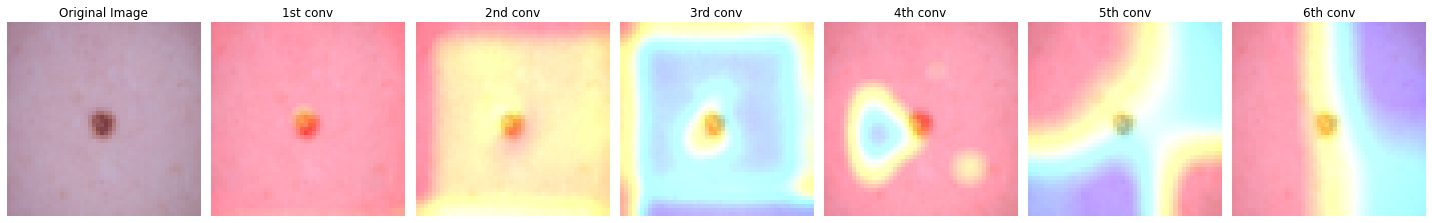

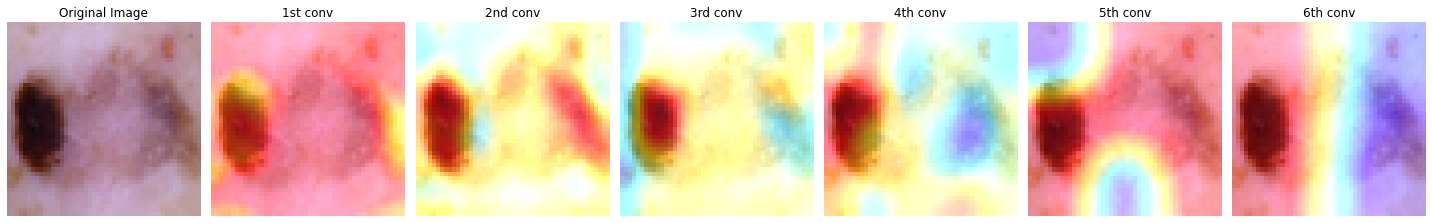

In [257]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Function to normalize heatmap values between 0 and 1
def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    return (array - min_val) / (max_val - min_val) if max_val > min_val else array

# Custom Grad-CAM function with broader focus
def wide_focus_grad_cam(model, img, class_index, layer_name, threshold=0.1):
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    
    # Get the output of the specified convolutional layer
    conv_layer = model.get_layer(layer_name).output
    grad_model = tf.keras.models.Model([model.inputs], [conv_layer, model.output])
    
    # Forward pass through the model to get feature maps and predictions
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_index]
    
    # Compute the gradients of the class output w.r.t. conv layer output
    grads = tape.gradient(loss, conv_outputs)
    
    # Channel-wise mean of gradients
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel in the conv layer output by corresponding weight
    cam_output = conv_outputs[0]
    grad_cam_output = np.dot(cam_output, weights.numpy())
    
    # Apply ReLU to retain positive influences (focus on broader influence)
    grad_cam_output = np.maximum(grad_cam_output, -0.5)  # Set to negative values to include wider regions
    
    # Normalize the heatmap to the range [0, 1]
    heatmap = normalize(grad_cam_output)
    
    # Apply thresholding to keep broader focus
    heatmap[heatmap < threshold] = threshold
    heatmap = normalize(heatmap)  # Re-normalize after thresholding
    
    return heatmap

# Function to blur and widen the Grad-CAM heatmap
def apply_wide_focus_heatmap(img, heatmap, alpha=0.3, kernel_size=15):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Apply GaussianBlur to widen the heatmap's focus area
    heatmap_resized = cv2.GaussianBlur(heatmap_resized, (kernel_size, kernel_size), 0)
    
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    # Overlay the heatmap on the original image
    superimposed_img = heatmap_colored * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255)
    
    return superimposed_img.astype(np.uint8)

# Function to display Grad-CAM with widened focus for multiple layers in the same row
def display_wide_focus_gradcam_row(model, X_test, Y_test, layer_names=None, num_samples=5, alpha=0.3):
    if layer_names is None:
        layer_names = ['prune_low_magnitude_conv2d_298', 'prune_low_magnitude_conv2d_299', 'prune_low_magnitude_conv2d_300', 'prune_low_magnitude_conv2d_301', 'prune_low_magnitude_conv2d_302', 'prune_low_magnitude_conv2d_303']  # Modify for your model layers
    
    custom_layer_titles = ['1st conv', '2nd conv', '3rd conv', '4th conv', '5th conv', '6th conv']  # Custom names
    
    for i in range(num_samples):
        img = X_test[i]  # Get the test image
        true_class = np.argmax(Y_test[i])  # Get true class label
        
        # Create subplots: 1 original image + 6 Grad-CAM heatmaps
        fig, axes = plt.subplots(1, len(layer_names) + 1, figsize=(20, 5))
        
        # Display the original image
        axes[0].imshow(img.astype(np.uint8))
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Generate and display Grad-CAM heatmaps for each layer
        for j, (layer, title) in enumerate(zip(layer_names, custom_layer_titles)):
            heatmap = wide_focus_grad_cam(model, img, class_index=true_class, layer_name=layer, threshold=0.4)
            superimposed_img = apply_wide_focus_heatmap(img, heatmap, alpha=alpha)
            
            # Display the Grad-CAM heatmap with the custom title
            axes[j + 1].imshow(superimposed_img)
            axes[j + 1].set_title(f"{title}")
            axes[j + 1].axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage: Displaying original and Grad-CAM heatmaps for 6 layers in the same row with custom titles
layer_names = ['prune_low_magnitude_conv2d_298', 'prune_low_magnitude_conv2d_299', 'prune_low_magnitude_conv2d_300', 'prune_low_magnitude_conv2d_301', 'prune_low_magnitude_conv2d_302', 'prune_low_magnitude_conv2d_303']  # Modify based on your model
display_wide_focus_gradcam_row(pruned_model_50, X_test_orig, Y_test_orig, num_samples=40, layer_names=layer_names, alpha=0.5)


In [267]:
model.save('/kaggle/working/fianl_gradcam_pruned_model.h5')